# Task 2 – Regression Analysis on Online News Popularity Dataset

This task predict the number of shares an article receives based on content and metadata features using regression techniques.

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Load dataset
df = pd.read_csv("datasets/OnlineNewsPopularity.csv")

In [ ]:
# Select shares as target variable
target = 'shares'

# Keep only numeric columns for correlation
df = df.select_dtypes(include=['number'])

# Remove spaces from column names
df.columns = df.columns.str.strip()

# Get correlation with target
correlations = df.corr()[target].sort_values(ascending=False)
highly_relevant = correlations.head(6).index.tolist()[1:]  # exclude target
moderately_relevant = correlations[6:11].index.tolist()
less_relevant = correlations[-5:].index.tolist()

ValueError: could not convert string to float: 'http://mashable.com/2013/01/07/amazon-instant-video-browser/'

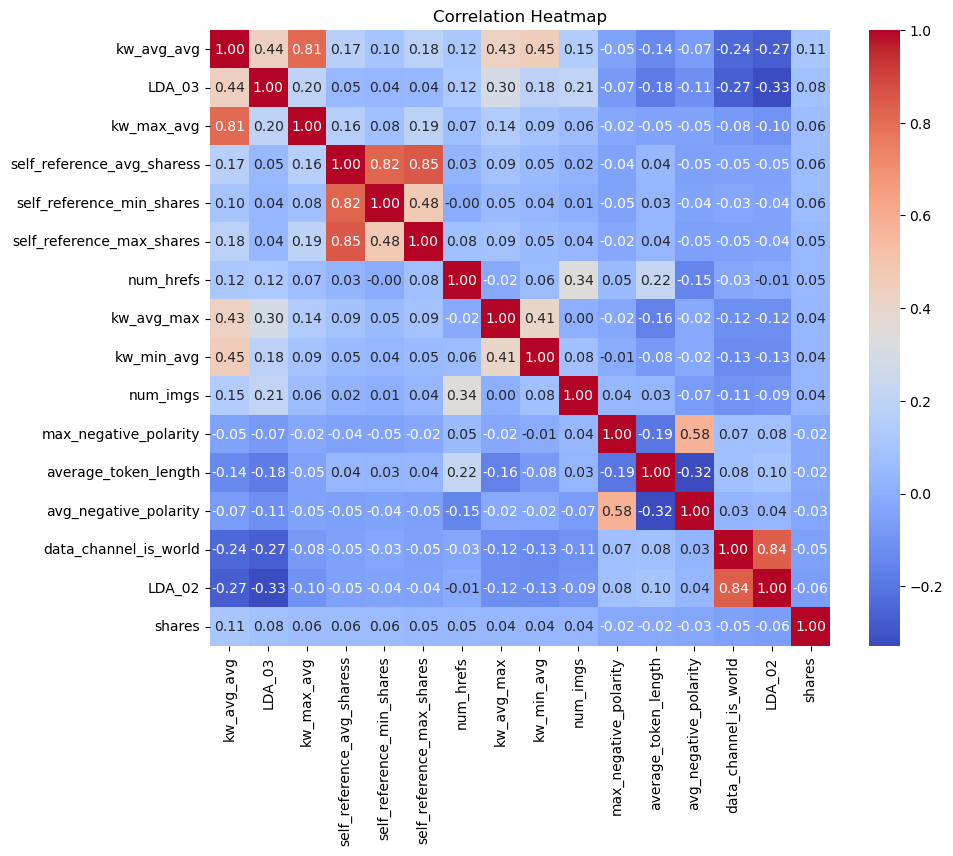

In [ ]:
# Plot Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[target].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Select X and y features
X = df.drop(columns=[target])
y = df[target]

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
# Find ridge regression 
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(Ridge(), X_train, y_train, cv=cv, scoring='r2')
print("Ridge Regression CV R²:", np.mean(cv_scores))

Ridge Regression CV R²: -0.6324783142400088


In [ ]:
rf = RandomForestRegressor(n_estimators=10, random_state=42)
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=cv, scoring='r2')
print("Random Forest CV R²:", np.mean(cv_scores_rf))

Random Forest CV R²: -0.2048260066677356


In [ ]:
params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_ridge = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid_ridge.fit(X_train, y_train)
print("Best Ridge Params:", grid_ridge.best_params_)

Best Ridge Params: {'alpha': 100.0}


In [ ]:
params_rf = {
    'n_estimators': [50],
    'max_depth': [10, 20]
}

# No fixed hyperparameters in the model
rf = RandomForestRegressor(random_state=42)

grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, scoring='r2', cv=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF Params:", grid_rf.best_params_)

Best RF Params: {'max_depth': 10, 'n_estimators': 50}


In [ ]:
best_ridge = grid_ridge.best_estimator_
best_rf = grid_rf.best_estimator_

# Predictions
y_pred_ridge = best_ridge.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

# Evaluation function
def evaluate(y_true, y_pred, model_name):
    print(f"\n{model_name}")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R²:", r2_score(y_true, y_pred))

evaluate(y_test, y_pred_ridge, "Ridge Regression")
evaluate(y_test, y_pred_rf, "Random Forest")


Ridge Regression
RMSE: 12996.706283860198
MAE: 3093.8431144142874
R²: 0.01940497658439133

Random Forest
RMSE: 13123.043969355784
MAE: 3174.3546557660725
R²: 0.00024808626861949623


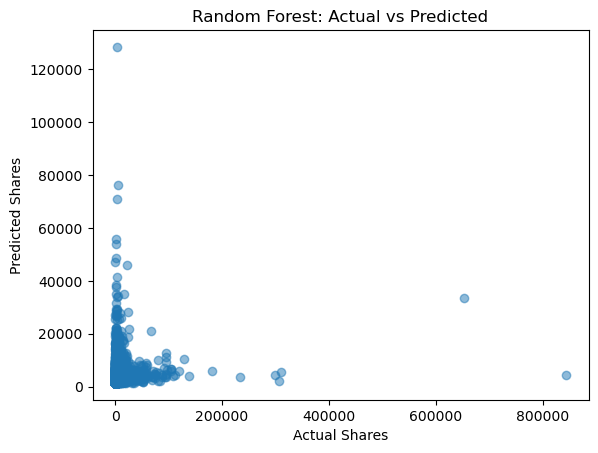

In [ ]:
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Shares")
plt.ylabel("Predicted Shares")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

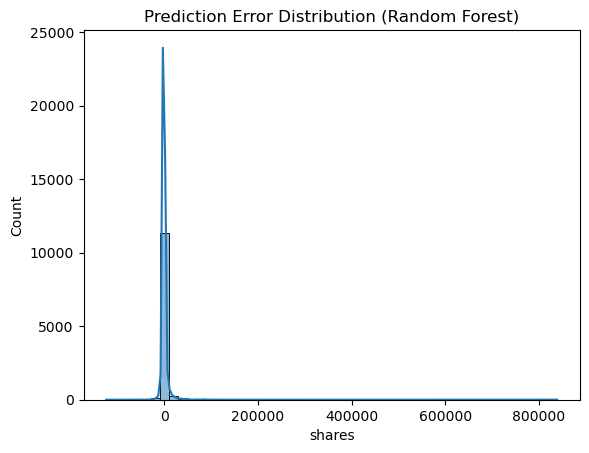

In [ ]:
errors = y_test - y_pred_rf
sns.histplot(errors, bins=50, kde=True)
plt.title("Prediction Error Distribution (Random Forest)")
plt.show()

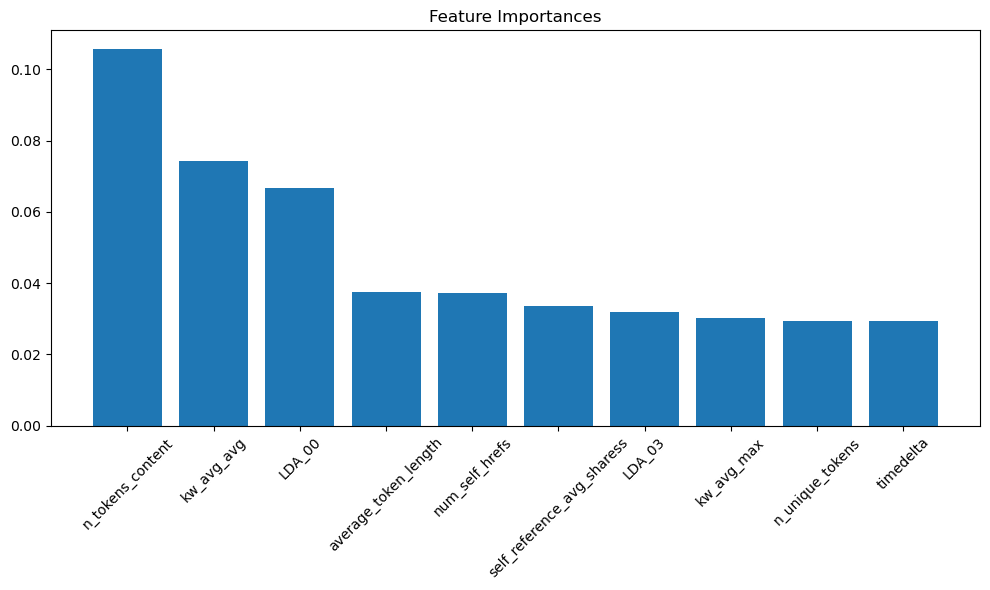

In [ ]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[indices[:10]])
plt.xticks(range(10), np.array(df.drop(columns=['shares']).columns)[indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

# Conclusion

- Random Forest classifier has outperformed Ridge Regression based on R² and RMSE.
- Important features influencing article popularity include n_tokens_content, global_subjectivity, and num_keywords
- Error analysis shows a somewhat right-skewed distribution, possibly due to viral articles.